# Setup

## Imports

In [1]:
import numpy as np
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
import dobbi
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import eli5
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import time
import math
from IPython.display import clear_output
from tqdm import tqdm

c:\Users\yaram\miniconda3\envs\pytorch_1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants

In [2]:
RANDOM_STATE = 42
N_FEATURES = 2**10
BATCH_SIZE = 31

## Functions

In [3]:
def replace_numbers(s):
    return re.sub('\d+', ' TOKEN_NUMBER ', s)
    
preprocess = dobbi.replace() \
    .url() \
    .html('') \
    .punctuation() \
    .whitespace() \
    .function()

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, n_step=100):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        X = batch[0]
        y = batch[1]
        optimizer.zero_grad()

        output = model(X).view(-1)
        loss = criterion(output, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%n_step==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()
    return epoch_loss / len(iterator)

In [6]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            X = batch[0]
            y = batch[1]
            output = model(X).view(-1)
            loss = criterion(output, y)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [7]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [8]:
def predict(model, iterator):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            X = batch[0]
            y = batch[1]
            output = model(X).view(-1)
            y_pred += output.cpu().numpy().tolist()
            y_true += y.cpu().numpy().tolist()
    return y_true, y_pred

# Data

## Load

In [9]:
IMDB_DATASET = load_dataset('imdb')

Found cached dataset imdb (C:/Users/yaram/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|██████████| 3/3 [00:00<00:00, 20.86it/s]


In [10]:
IMDB_DATASET

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [11]:
IMDB_DATASET['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [12]:
df_train = pd.DataFrame(IMDB_DATASET['train']).copy()
df_train, df_val = train_test_split(df_train, test_size=0.2, 
    random_state=RANDOM_STATE, stratify=df_train['label'])

df_test = pd.DataFrame(IMDB_DATASET['test']).copy()

In [13]:
df_train

,text,label
20022,I have always been a huge James Bond fanatic! ...,1
4993,I am a Christian and I say this movie had terr...,0
24760,"Neatly sandwiched between THE STRANGER, a smal...",1
13775,Years ago I did follow a soap on TV. So I was ...,1
20504,"Here's a gritty, get-the-bad guys revenge stor...",1
...,...,...
22580,Popular radio storyteller Gabriel No one(Robin...,1
20473,"Throughout this film, you might think this fil...",1
10468,Quite what the producers of this appalling ada...,0
5163,"""Trigger Man"" is definitely the most boring an...",0


## Preprocess

In [14]:
df_train['text'] = df_train['text'].str.lower()
df_train['text'] = df_train['text'].apply(replace_numbers)
df_train['text'] = df_train['text'].apply(preprocess)

In [15]:
df_val['text'] = df_val['text'].str.lower()
df_val['text'] = df_val['text'].apply(replace_numbers)
df_val['text'] = df_val['text'].apply(preprocess)

In [16]:
df_test['text'] = df_test['text'].str.lower()
df_test['text'] = df_test['text'].apply(replace_numbers)
df_test['text'] = df_test['text'].apply(preprocess)

In [17]:
df_train.iloc[0]['text']

'i have always been a huge james bond fanatic i have seen almost all of the films except for die another day and the world is not enough the graphic s for everything or nothing are breathtaking the voice talents wow i love pierce brosnan he is finally bond in a video game he is bond i enjoyed the past bond games goldeneye the world is not enough agent under fire and nightfire this one is definitely the best finally mr brosnan may i call him mr brosnan as a sign of respect yes i can he was phenomenally exciting to hear in a video game at long last duh i ve seen him perform with robin williams and let me tell you they make a great team pierce brosnan is funny wickedly handsome i mean to say wickedly in a good way and just one of those actor s who you would want to walk up to and wrap your arms around and hug saying pierce brosnan thank you for being james bond if it wasn t for you i wouldn t know who james bond is he s a great actor i am a huge fan of willem dafoe even though i ve seen h

## Vectorize

In [18]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), lowercase=True, max_features=N_FEATURES)

In [19]:
%%time
X_train_text = vectorizer.fit_transform(df_train['text'])
X_val_text = vectorizer.transform(df_val['text'])
X_test_text = vectorizer.transform(df_test['text'])


CPU times: total: 28.8 s
Wall time: 28.9 s


In [20]:
len(vectorizer.get_feature_names_out())

1024

## ToTensor

In [21]:
%%time

# convert the data to torch tensors
train_inputs = torch.tensor(X_train_text.toarray(), dtype=torch.float32)
train_labels = torch.tensor(df_train['label'].to_numpy(), dtype=torch.float32)
valid_inputs = torch.tensor(X_val_text.toarray(), dtype=torch.float32)
valid_labels = torch.tensor(df_val['label'].to_numpy(), dtype=torch.float32)
test_inputs = torch.tensor(X_test_text.toarray(), dtype=torch.float32)
test_labels = torch.tensor(df_test['label'].to_numpy(), dtype=torch.float32)

# create TensorDataset
train_dataset = TensorDataset(train_inputs, train_labels)
valid_dataset = TensorDataset(valid_inputs, valid_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

# create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

loaders = {
    "train": train_dataloader,
    "val": valid_dataloader,
}

CPU times: total: 969 ms
Wall time: 211 ms


# Model

## Baseline 1 - LogReg

In [22]:
logreg = LogisticRegression(random_state=RANDOM_STATE, n_jobs=4)

In [23]:
%%time
logreg.fit(X_train_text, df_train['label'])

CPU times: total: 328 ms
Wall time: 1.94 s


LogisticRegression(n_jobs=4, random_state=42)

In [24]:
eli5.show_weights(estimator=logreg, 
                  feature_names=list(vectorizer.get_feature_names_out()),
                  top=(15, 10))

Weight?,Feature
+5.693,excellent
+5.305,great
+4.685,best
+4.598,perfect
+4.421,wonderful
+4.271,amazing
+3.859,favorite
+3.393,brilliant
+3.379,loved
+3.337,perfectly


In [25]:
y_pred = logreg.predict(X_test_text)

acc = accuracy_score(df_test['label'], y_pred)
f1_micro = f1_score(df_test['label'], y_pred, average='micro')
f1_macro = f1_score(df_test['label'], y_pred, average='macro')

print(f"Accuracy: {acc}\nF1(micro): {f1_micro}\nF1(macro): {f1_macro}")

Accuracy: 0.85268
F1(micro): 0.85268
F1(macro): 0.8526580696270833


## Baseline 1 - LogReg (PT)

In [157]:
class FFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FFNN, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
        
    def forward(self, x):
        x = F.sigmoid(self.fc(x))
        return x
    
input_size = N_FEATURES
num_classes = 1

model = FFNN(input_size, num_classes)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,025 trainable parameters


In [158]:
train_history = []
valid_history = []

N_EPOCHS = 1
CLIP = 1
learning_rate = 0.01

best_valid_loss = float('inf')
early_stopping_counter = 0
early_stopping_criteria = 2
lr_on_plateau_update = 0.2
min_lr = 0.0001

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

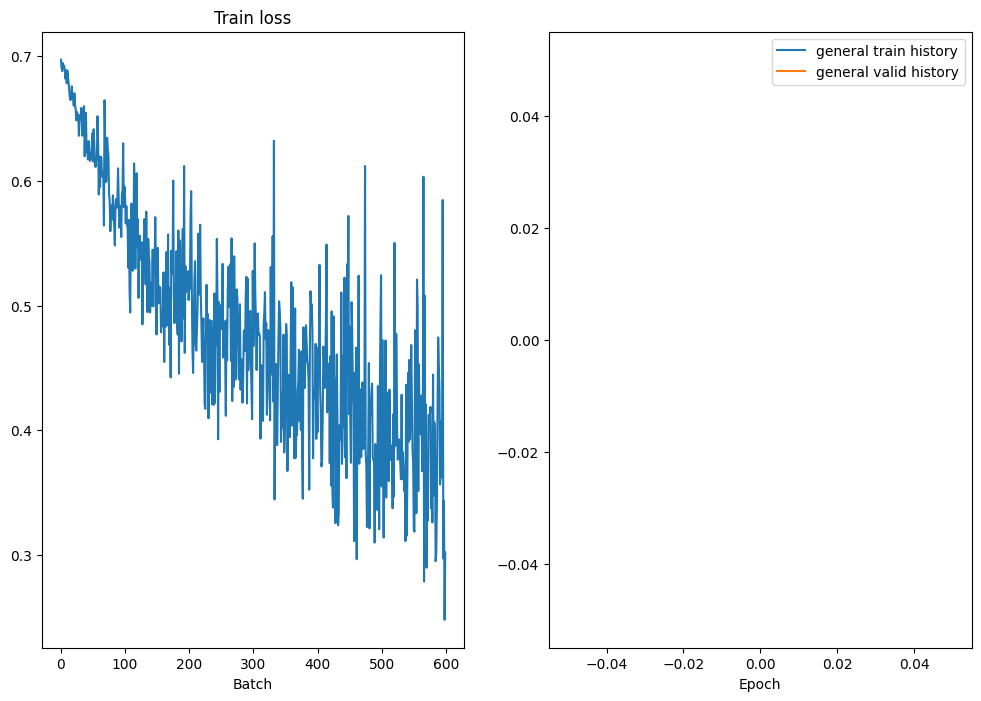

Epoch: 01 | Time: 0m 3s
Total training time: 0m 3s


In [159]:
st = time.time()
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        learning_rate = max(min_lr, learning_rate * lr_on_plateau_update)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(f"LR on pleataeu update. New LR: {learning_rate}")
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    if early_stopping_counter >= early_stopping_criteria:
        print(f"Early stopping, reached limit: {early_stopping_criteria}")
        break
tt = epoch_time(st, time.time())

print(f'Total training time: {epoch_mins}m {epoch_secs}s')
model.load_state_dict(torch.load('model.pt'));

In [160]:
y_true, y_pred = predict(model, test_dataloader)
y_pred = list(map(round, y_pred))

acc = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {acc}\nF1(micro): {f1_micro}\nF1(macro): {f1_macro}")

Accuracy: 0.8486
F1(micro): 0.8486
F1(macro): 0.8485594670019193


## Baseline 2 - FFNN

In [44]:
class FFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FFNN, self).__init__()
        hidden_size1 = 1024
        hidden_size2 = 1024
        hidden_size3 = 1024
        
        self.fc1 = nn.Linear(input_size, hidden_size1)  # 1024x1024
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # 1024x1024
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)  # 1024x1024
        self.fc4 = nn.Linear(hidden_size3, num_classes)  # 1024x1
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x
    
input_size = N_FEATURES
num_classes = 1

model = FFNN(input_size, num_classes)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 3,149,825 trainable parameters


In [45]:
model

FFNN(
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1, bias=True)
)

In [46]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1
learning_rate = 0.01

best_valid_loss = float('inf')
early_stopping_counter = 0
early_stopping_criteria = 3
lr_on_plateau_update = 0.2
min_lr = 0.0001

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

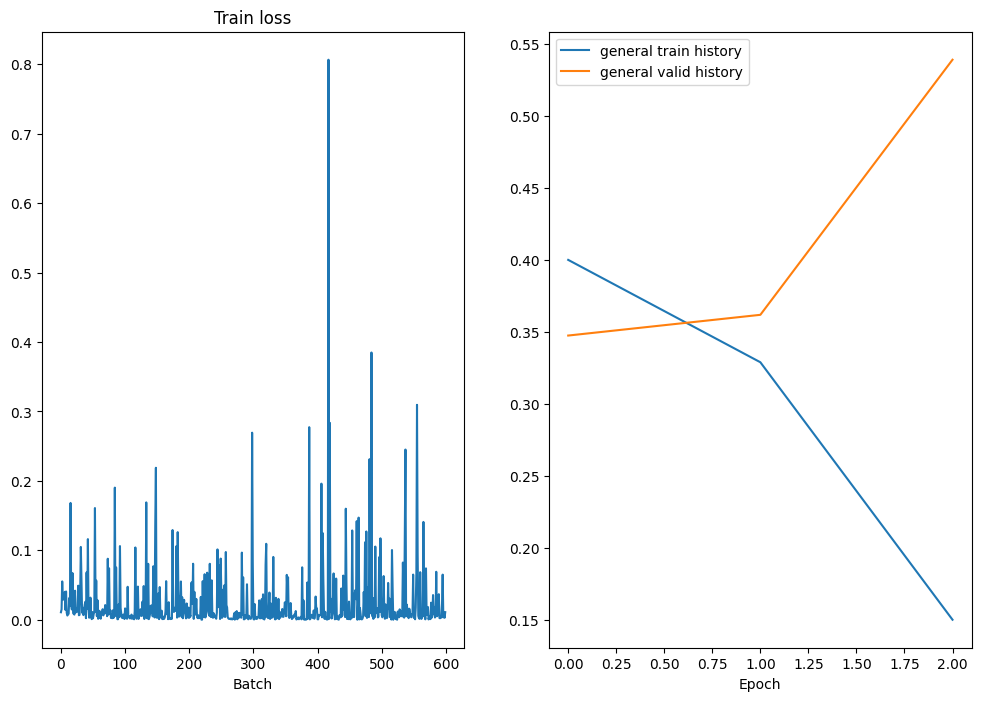

LR on pleataeu update. New LR: 0.0001
Epoch: 04 | Time: 0m 22s
Early stopping, reached limit: 3
Total training time: (1, 46)m (1, 46)s


In [47]:
st = time.time()
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        learning_rate = max(min_lr, learning_rate * lr_on_plateau_update)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(f"LR on pleataeu update. New LR: {learning_rate}")
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    if early_stopping_counter >= early_stopping_criteria:
        print(f"Early stopping, reached limit: {early_stopping_criteria}")
        break
tt_m, tt_s = epoch_time(st, time.time())

print(f'Total training time: {tt_m}m {tt_s}s')
model.load_state_dict(torch.load('model.pt'));

In [48]:
y_true, y_pred = predict(model, test_dataloader)
y_pred = list(map(round, y_pred))

acc = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {acc}\nF1(micro): {f1_micro}\nF1(macro): {f1_macro}")

Accuracy: 0.84632
F1(micro): 0.84632
F1(macro): 0.8462580102457824


## HyperCube FFNN

In [49]:
class HyperCubeBlock(nn.Module):
    def __init__(self, input_size, output_size, compression=2):
        """"Compression factor 2 means there is only one transpose operation."""
        super(HyperCubeBlock, self).__init__()
        assert input_size % compression == 0
        assert input_size == output_size
        self.hc_input_size = int(np.sqrt(input_size))
        self.hc_layers_1 = []
        self.hc_layers_2 = []
        for i in range(self.hc_input_size):
            self.hc_layers_1.append(nn.Linear(self.hc_input_size, self.hc_input_size))
            self.hc_layers_2.append(nn.Linear(self.hc_input_size, self.hc_input_size))
        self.hc_layers_1 = nn.ModuleList(self.hc_layers_1)
        self.hc_layers_2 = nn.ModuleList(self.hc_layers_2)
            
    def forward(self, x):
        x = x.reshape((x.shape[0],self.hc_input_size,self.hc_input_size))  # To HC, x.shape[0]=batch_size
        out = []
        for i in range(self.hc_input_size):
            out.append(self.hc_layers_1[i](x[:,i,:]))  # TODO: replace with matrix multiplication instead of iter
            # out.append(F.relu(self.hc_layers_1[i](x[:,i,:])))  # test
        x = torch.stack(out)
        x = x.transpose(0,1)  # !Check: not sure it's correct
        x = x.transpose(1,2)
        for i in range(self.hc_input_size):
            out.append(self.hc_layers_2[i](x[:,i,:]))  # TODO: replace with matrix multiplication instead of iter
            # out.append(F.relu(self.hc_layers_2[i](x[:,i,:])))  # test
        x = x.reshape((x.shape[0],self.hc_input_size*self.hc_input_size))  # Flatten, x.shape[0]=batch_size
        return x


class HC_FFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HC_FFNN, self).__init__()
        hidden_size1 = 1024
        hidden_size2 = 1024
        hidden_size3 = 1024

        self.fc1 = HyperCubeBlock(input_size, hidden_size1)  # HC 1024x1024: 2^10 -> 2^10
        self.fc2 = HyperCubeBlock(hidden_size1, hidden_size2)  # HC 1024x1024: 2^10 -> 2^10
        self.fc3 = HyperCubeBlock(hidden_size2, hidden_size3)  # HC 1024x1024: 2^10 -> 2^10
        self.fc4 = nn.Linear(hidden_size3, num_classes)  # 1024x1
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x
    
input_size = N_FEATURES
num_classes = 1

model = HC_FFNN(input_size, num_classes)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 203,777 trainable parameters


In [50]:
# model

In [51]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1
learning_rate = 0.01

best_valid_loss = float('inf')
early_stopping_counter = 0
early_stopping_criteria = 3
lr_on_plateau_update = 0.2
min_lr = 0.0001

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

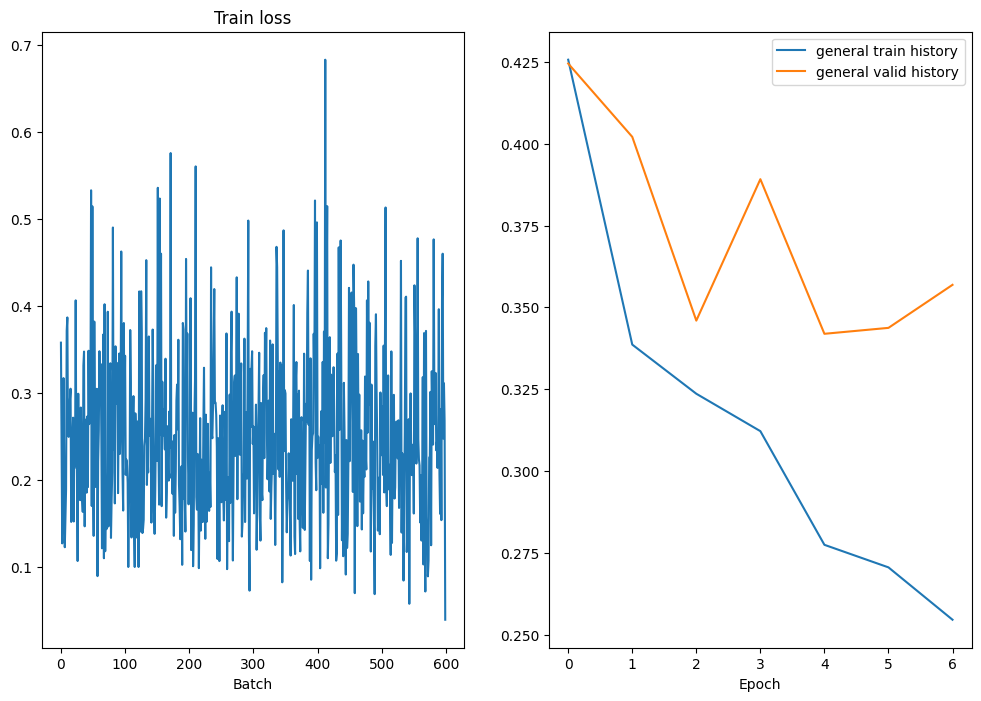

LR on pleataeu update. New LR: 0.0001
Epoch: 08 | Time: 0m 26s
Early stopping, reached limit: 3
Total training time: (3, 33)m (3, 33)s


In [52]:
st = time.time()
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        learning_rate = max(min_lr, learning_rate * lr_on_plateau_update)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(f"LR on pleataeu update. New LR: {learning_rate}")
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    if early_stopping_counter >= early_stopping_criteria:
        print(f"Early stopping, reached limit: {early_stopping_criteria}")
        break
tt_m, tt_s = epoch_time(st, time.time())

print(f'Total training time: {tt_m}m {tt_s}s')
model.load_state_dict(torch.load('model.pt'));

In [53]:
y_true, y_pred = predict(model, test_dataloader)
y_pred = list(map(round, y_pred))

acc = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {acc}\nF1(micro): {f1_micro}\nF1(macro): {f1_macro}")

Accuracy: 0.85076
F1(micro): 0.85076
F1(macro): 0.8507590522602855


## HyperCube FFNN (low-level optimized)

### Linear layer 2D operation

In [157]:
inp = torch.tensor([
    [1,2,3],
    [4,5,6]
])
inp.shape

torch.Size([2, 3])

In [158]:
w = torch.tensor([
    [
        [1,1,1],
        [2,2,2],
        [3,3,3],
        [4,4,4]
    ],
    [
        [5,5,5],
        [6,6,6],
        [7,7,7],
        [8,8,8]
    ]
])
w.shape

torch.Size([2, 4, 3])

In [161]:
out = inp.expand((4,2,3)).transpose(0,1)
out, out.shape

(tensor([[[1, 2, 3],
          [1, 2, 3],
          [1, 2, 3],
          [1, 2, 3]],
 
         [[4, 5, 6],
          [4, 5, 6],
          [4, 5, 6],
          [4, 5, 6]]]),
 torch.Size([2, 4, 3]))

In [98]:
def linear_2d(x, w, b=None):
    """
    v1: 2D input matrix, no bias

    inp:
    - dim 0 (equal to w.shape[0]) is common with the weight matrix w and preserved after the computation
    - dim 1 (equal to w.shape[2]) is used to constract the new set of features of a new size (w.shape[1])

    w:
    - dim 0 (equal to x.shape[0]) is common with the input and preserves the dimension of the input
    - dim 1 is the new contracted feature representation
    - dim 2 (equal to x.shape[1]) is of the size of the initial set of features
    """
    x = x.expand((4,2,3)).transpose(0,1) * w
    return torch.sum(x, axis=2)

In [99]:
linear_2d(inp, w), linear_2d(inp, w).shape

tensor([[  6,  12,  18,  24],
        [ 75,  90, 105, 120]])

In [102]:
b = torch.tensor([
    0.1,0.2,0.3, 0.4
])
b.shape

torch.Size([4])

In [105]:
def linear_2d(x, w, b=None):
    """
    v2: 2D input matrix, with bias

    inp:
    - dim 0 (equal to w.shape[0]) is common with the weight matrix w and preserved after the computation
    - dim 1 (equal to w.shape[2]) is used to construct the new set of features of a new size (w.shape[1])

    w:
    - dim 0 (equal to x.shape[0]) is common with the input and preserves the dimension of the input
    - dim 1 is the new constructed feature representation
    - dim 2 (equal to x.shape[1]) is of the size of the initial set of features

    b:
    - dim 0 (equal to w.shape[1]) bias for each of the new feature representations
    """
    x = x.expand((4,2,3)).movedim(0,1) * w
    x = torch.sum(x, axis=2) + b.expand((2,4))
    return x

In [106]:
linear_2d(inp, w, b)

tensor([[  6.1000,  12.2000,  18.3000,  24.4000],
        [ 75.1000,  90.2000, 105.3000, 120.4000]])

input must be of size (N, *, n_2d_layers, in_features),
where N - is the number of samples in the batch, * - additional dimensions.

In [186]:
inp = torch.tensor([
    [[1,2,3],[4,5,6]],
    [[10,20,30],[40,50,60]]
])
inp.shape

torch.Size([2, 2, 3])

In [217]:
b = torch.tensor([
    [0.1,0.2,0.3,0.4],
    [0.5,0.6,0.7,0.8]
])
b.shape

torch.Size([2, 4])

In [213]:
def linear_2d(x, w, b=None):
    """
    v3: 3D input matrix, with bias, generalized.

    x:
    - dim 0 is the number of samples in the batch
    - dim 1 (equal to w.shape[0]) is common with the weight matrix w and preserved after the computation
    - dim 2 (equal to w.shape[2]) is used to construct the new set of features of a new size (w.shape[1])

    w:
    - dim 0 (equal to x.shape[1]) is common with the input and preserves the dimension of the input
    - dim 1 is the new constructed feature representation
    - dim 2 (equal to x.shape[2]) is of the size of the initial set of features

    b:
    - dim 0 (equal to x.shape[1]) is common with the input and preserves the dimension of the input
    - dim 1 (equal to w.shape[1]) bias for each of the new feature representations

    out:
    - dim 0 is the number of samples in the batch
    - dim 1 (equal to w.shape[0]) is common with the weight matrix w and preserved after the computation
    - dim 2 is the new constructed feature representation
    """
    nf = w.shape[1]
    x = x.expand((nf,*x.shape)).movedim(0,-2) * w
    x = torch.sum(x, axis=-1) + b
    return x

In [189]:
out = inp.expand((4,2,2,3))

In [190]:
w.shape

torch.Size([2, 4, 3])

In [191]:
# out = out.permute(1,2,0,3)
# out, out.shape
out = out.movedim(0,2)
out, out.shape

(tensor([[[[ 1,  2,  3],
           [ 1,  2,  3],
           [ 1,  2,  3],
           [ 1,  2,  3]],
 
          [[ 4,  5,  6],
           [ 4,  5,  6],
           [ 4,  5,  6],
           [ 4,  5,  6]]],
 
 
         [[[10, 20, 30],
           [10, 20, 30],
           [10, 20, 30],
           [10, 20, 30]],
 
          [[40, 50, 60],
           [40, 50, 60],
           [40, 50, 60],
           [40, 50, 60]]]]),
 torch.Size([2, 2, 4, 3]))

In [192]:
w

tensor([[[1, 1, 1],
         [2, 2, 2],
         [3, 3, 3],
         [4, 4, 4]],

        [[5, 5, 5],
         [6, 6, 6],
         [7, 7, 7],
         [8, 8, 8]]])

In [193]:
out * w

tensor([[[[  1,   2,   3],
          [  2,   4,   6],
          [  3,   6,   9],
          [  4,   8,  12]],

         [[ 20,  25,  30],
          [ 24,  30,  36],
          [ 28,  35,  42],
          [ 32,  40,  48]]],


        [[[ 10,  20,  30],
          [ 20,  40,  60],
          [ 30,  60,  90],
          [ 40,  80, 120]],

         [[200, 250, 300],
          [240, 300, 360],
          [280, 350, 420],
          [320, 400, 480]]]])

In [218]:
out = inp.expand((4,2,2,3)).movedim(0,-2) * w
out, out.shape

(tensor([[[[  1,   2,   3],
           [  2,   4,   6],
           [  3,   6,   9],
           [  4,   8,  12]],
 
          [[ 20,  25,  30],
           [ 24,  30,  36],
           [ 28,  35,  42],
           [ 32,  40,  48]]],
 
 
         [[[ 10,  20,  30],
           [ 20,  40,  60],
           [ 30,  60,  90],
           [ 40,  80, 120]],
 
          [[200, 250, 300],
           [240, 300, 360],
           [280, 350, 420],
           [320, 400, 480]]]]),
 torch.Size([2, 2, 4, 3]))

In [219]:
b

tensor([[0.1000, 0.2000, 0.3000, 0.4000],
        [0.5000, 0.6000, 0.7000, 0.8000]])

In [220]:
torch.sum(out, axis=3) + b

tensor([[[   6.1000,   12.2000,   18.3000,   24.4000],
         [  75.5000,   90.6000,  105.7000,  120.8000]],

        [[  60.1000,  120.2000,  180.3000,  240.4000],
         [ 750.5000,  900.6000, 1050.7000, 1200.8000]]])

In [214]:
inp, inp.shape

(tensor([[[ 1,  2,  3],
          [ 4,  5,  6]],
 
         [[10, 20, 30],
          [40, 50, 60]]]),
 torch.Size([2, 2, 3]))

In [215]:
w, w.shape

(tensor([[[1, 1, 1],
          [2, 2, 2],
          [3, 3, 3],
          [4, 4, 4]],
 
         [[5, 5, 5],
          [6, 6, 6],
          [7, 7, 7],
          [8, 8, 8]]]),
 torch.Size([2, 4, 3]))

In [222]:
b, b.shape

(tensor([[0.1000, 0.2000, 0.3000, 0.4000],
         [0.5000, 0.6000, 0.7000, 0.8000]]),
 torch.Size([2, 4]))

In [225]:
out = linear_2d(inp, w, b)
out, out.shape

(tensor([[[   6.1000,   12.2000,   18.3000,   24.4000],
          [  75.5000,   90.6000,  105.7000,  120.8000]],
 
         [[  60.1000,  120.2000,  180.3000,  240.4000],
          [ 750.5000,  900.6000, 1050.7000, 1200.8000]]]),
 torch.Size([2, 2, 4]))

F.linear:

* x: (batch_size,in_features)
* w: (in_features,out_features)
* b: (out_features)
* out: (batch_size,out_features)

linear_2d

* x: (batch_size,n_2d_layers,in_features)
* w: (in_features,n_2d_layers,out_features)  * here can be some changes
* b: (n_2d_layers,out_features)
* out: (batch_size,n_2d_layers,out_features)

In [ ]:
x  # batch_size, n_2d_layers, in_features
nf = w.shape[1]  # out_features
x = x.expand((nf,*x.shape))  # out_features, batch_size, n_2d_layers, in_features

x = x.movedim(0,-2)  # batch_size, n_2d_layers, out_features, in_features
x = x * w
x  # batch_size, n_2d_layers, out_features, in_features
x = torch.sum(x, axis=-1)  # batch_size, n_2d_layers, out_features

x = x + b  # batch_size, n_2d_layers, out_features + n_2d_layers, out_features
x  # batch_size, n_2d_layers, out_features

### Linear 3D layer and HC block

In [247]:
def linear_2d(x, w, b=None):
    x = x.expand((w.shape[1],*x.shape)).movedim(0,-2) * w
    x = torch.sum(x, axis=-1) + b
    return x

In [250]:
class Linear3D(nn.Module):
    """
    This is a 3D linear layer. It represents `n_2d_layers` 
    2D linear layers and performs a dimension-wise multiplication.
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in_features: int, n_2d_layers: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_2d_layers = n_2d_layers
        self.weight = nn.Parameter(torch.empty((in_features,n_2d_layers,out_features), **factory_kwargs))
        if bias:
            self.bias = nn.Parameter(torch.empty((n_2d_layers,out_features), **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        input must be of size (N, *, n_2d_layers, in_features),
        where N - is the number of samples in the batch, * - additional dimensions.
        """
        return linear_2d(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, n_2d_layers={}, out_features={}, bias={}'.format(
            self.in_features, self.n_2d_layers, self.out_features, self.bias is not None
        )

In [251]:
class HyperCubeBlock(nn.Module):
    def __init__(self, input_size, output_size, compression=2):
        """"Compression factor 2 means there is only one transpose operation."""
        super(HyperCubeBlock, self).__init__()
        assert input_size % compression == 0
        assert input_size == output_size
        self.hc_input_size = int(np.sqrt(input_size))
        self.hc_layers_1 = Linear3D(self.hc_input_size, self.hc_input_size, self.hc_input_size)
        self.hc_layers_2 = Linear3D(self.hc_input_size, self.hc_input_size, self.hc_input_size)
            
    def forward(self, x):
        x = x.reshape((x.shape[0],self.hc_input_size,self.hc_input_size))  # To HC, x.shape[0]=batch_size
        x = self.hc_layers_1(x)
        # x = x.transpose(0,1)  # !Check: not sure it's correct;
        x = x.transpose(1,2)
        x = self.hc_layers_2(x)
        # x = x.reshape((x.shape[0],self.hc_input_size*self.hc_input_size))  # Flatten, x.shape[0]=batch_size
        x = x.flatten(start_dim=-2, end_dim=-1)
        return x

### Experiment

In [252]:
class HC_FFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HC_FFNN, self).__init__()
        hidden_size1 = 1024
        hidden_size2 = 1024
        hidden_size3 = 1024

        self.hc1 = HyperCubeBlock(input_size, hidden_size1)  # HC 1024x1024: 2^10 -> 2^10
        self.hc2 = HyperCubeBlock(hidden_size1, hidden_size2)  # HC 1024x1024: 2^10 -> 2^10
        self.hc3 = HyperCubeBlock(hidden_size2, hidden_size3)  # HC 1024x1024: 2^10 -> 2^10
        self.fc4 = nn.Linear(hidden_size3, num_classes)  # 1024x1
        
    def forward(self, x):
        x = F.relu(self.hc1(x))
        x = F.relu(self.hc2(x))
        x = F.relu(self.hc3(x))
        x = F.sigmoid(self.fc4(x))
        return x
    
input_size = N_FEATURES
num_classes = 1

model = HC_FFNN(input_size, num_classes)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 203,777 trainable parameters


In [253]:
model

HC_FFNN(
  (fc1): HyperCubeBlock(
    (hc_layers_1): Linear3D(in_features=32, n_2d_layers=32, out_features=32, bias=True)
    (hc_layers_2): Linear3D(in_features=32, n_2d_layers=32, out_features=32, bias=True)
  )
  (fc2): HyperCubeBlock(
    (hc_layers_1): Linear3D(in_features=32, n_2d_layers=32, out_features=32, bias=True)
    (hc_layers_2): Linear3D(in_features=32, n_2d_layers=32, out_features=32, bias=True)
  )
  (fc3): HyperCubeBlock(
    (hc_layers_1): Linear3D(in_features=32, n_2d_layers=32, out_features=32, bias=True)
    (hc_layers_2): Linear3D(in_features=32, n_2d_layers=32, out_features=32, bias=True)
  )
  (fc4): Linear(in_features=1024, out_features=1, bias=True)
)

In [254]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1
learning_rate = 0.01

best_valid_loss = float('inf')
early_stopping_counter = 0
early_stopping_criteria = 3
lr_on_plateau_update = 0.2
min_lr = 0.0001

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

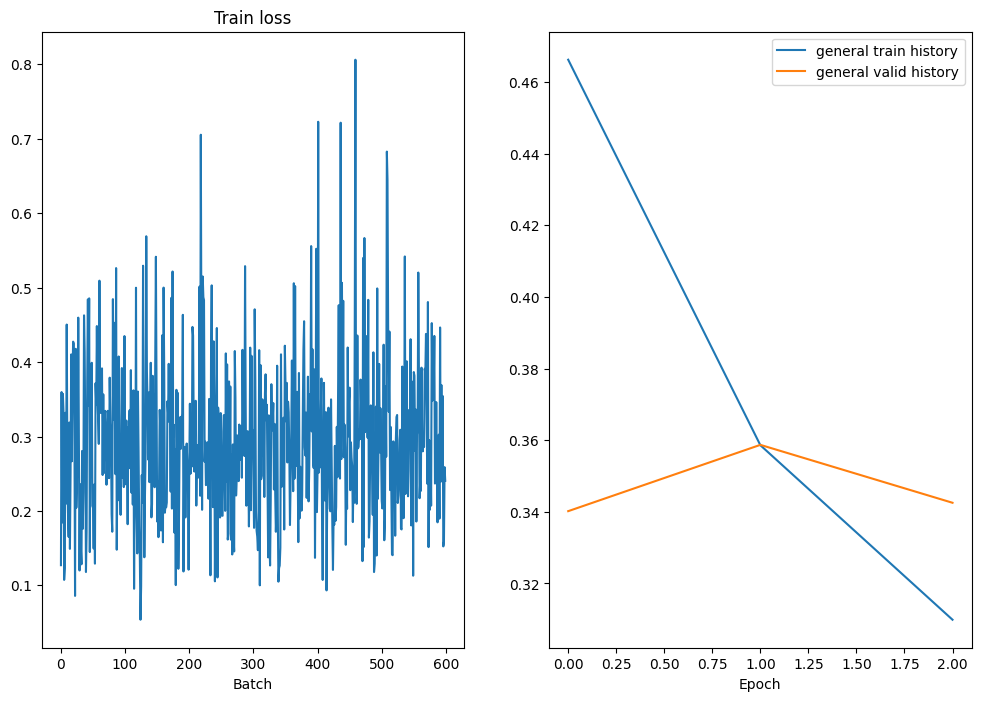

LR on pleataeu update. New LR: 0.0001
Epoch: 04 | Time: 0m 25s
Early stopping, reached limit: 3
Total training time: 1m 50s


In [255]:
st = time.time()
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        learning_rate = max(min_lr, learning_rate * lr_on_plateau_update)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(f"LR on pleataeu update. New LR: {learning_rate}")
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    if early_stopping_counter >= early_stopping_criteria:
        print(f"Early stopping, reached limit: {early_stopping_criteria}")
        break
tt_m, tt_s = epoch_time(st, time.time())

print(f'Total training time: {tt_m}m {tt_s}s')
model.load_state_dict(torch.load('model.pt'));

In [256]:
y_true, y_pred = predict(model, test_dataloader)
y_pred = list(map(round, y_pred))

acc = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {acc}\nF1(micro): {f1_micro}\nF1(macro): {f1_macro}")

Accuracy: 0.85072
F1(micro): 0.85072
F1(macro): 0.8507053084468652


## Self-reflection NN

In [ ]:
class PairwiseAttention(nn.Module):
    def __init__(self, input_size, output_size):
        super(PairwiseAttention, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x1 = self.fc(x)
        x = torch.mul(x, x1)
        return x


class FFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FFNN, self).__init__()
        hidden_size = 1024
        self.fc1 = PairwiseAttention(input_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        w = 10  # (?) Can make trainable with softmax over linear layer or multiplying sigm by 10
        for i in range(1, w):
            x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc4(x))
        return x

input_size = N_FEATURES
num_classes = 1

model = FFNN(input_size, num_classes)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [130]:
torch.tensor(
    [[1,2],
    [3,4]]
)[0]

tensor([1, 2])

In [129]:
torch.tensor([1,2,3,4])[:2]

tensor([1, 2])

In [132]:
torch.tensor([1,2,3,4]).reshape((2,2))

tensor([[1, 2],
        [3, 4]])

In [134]:
torch.tensor(
    [[1,2],
    [3,4]]
).transpose(0,1)

tensor([[1, 3],
        [2, 4]])

In [136]:
a = torch.tensor([1,2])
b = torch.tensor([3,4])
torch.stack([a,b])

tensor([1, 2, 3, 4])

In [ ]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

# Initialize the model
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = len(labels)
model = TextClassificationModel(vocab_size, embedding_dim, hidden_dim, output_dim)


In [ ]:
# split dataset into train, validation and test
train_data = IMDB_DATASET['train']
valid_data = IMDB_DATASET['train']
unsupervised_data = IMDB_DATASET['validation']
test_data = IMDB_DATASET['test']

# convert the data to torch tensors
train_inputs = torch.tensor(train_data[0], dtype=torch.long)
train_labels = torch.tensor(train_data[1], dtype=torch.long)
valid_inputs = torch.tensor(valid_data[0], dtype=torch.long)
valid_labels = torch.tensor(valid_data[1], dtype=torch.long)
test_inputs = torch.tensor(test_data[0], dtype=torch.long)
test_labels = torch.tensor(test_data[1], dtype=torch.long)

# create TensorDataset
train_dataset = TensorDataset(train_inputs, train_labels)
valid_dataset = TensorDataset(valid_inputs, valid_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

# create dataloader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader

# Model

# 

In [ ]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

# Initialize the model
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = len(labels)
model = TextClassificationModel(vocab_size, embedding_dim, hidden_dim, output_dim)


In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x is of shape (batch_size, seq_len, d_model)
        query = self.query(x)  # (batch_size, seq_len, d_model)
        key = self.key(x)  # (batch_size, seq_len, d_model)
        value = self.value(x)  # (batch_size, seq_len, d_model)

        # Compute the dot product between query and key
        dot_product = torch.matmul(query, key.transpose(-1, -2))  # (batch_size, seq_len, seq_len)
        
        # Scale dot_product by d_model
        dot_product = dot_product / (self.d_model ** 0.5)
        
        # Apply the softmax function to the dot product
        attention = self.softmax(dot_product)  # (batch_size, seq_len, seq_len)

        # Compute the weighted sum of the values using the attention scores
        out = torch.matmul(attention, value)  # (batch_size, seq_len, d_model)
        return out


In [ ]:
import transformers
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch

# Load the BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(glue_tasks))

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the optimizer and schedule
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loop over the data
for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):
        # Move the data to the GPU
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
        model.train()
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    # Evaluation
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in eval_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
        with torch.no_grad():
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]
            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)
    result = compute_metrics(preds, out_label_ids)
    print(f'Epoch {epoch+1} loss: {eval_loss}, acc: {result["acc"]}')
